<a href="https://colab.research.google.com/github/iridescentZYX/ML/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
print(torch.__version__)

2.4.1+cu121


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear
from torch.utils.tensorboard import SummaryWriter
from torch.nn import ReLU6
import time

# 定义训练的设备，是用cpu进行训练测试还是gpu进行测试训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构建训练数据集dataset_train
dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# 构建测试数据集dataset_test
dataset_test = torchvision.datasets.CIFAR10(root="./dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_len = len(dataset_train)
test_len = len(dataset_test)
print(f"训练数据集的长度为:{train_len}")       # 输出训练集和测试集的长度
print(f"测试数据集的长度为:{test_len}")

# 加载训练集train_loader
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64)

# 加载测试集test_loader
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64)


class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.model = nn.Sequential(
            # 卷积层，参数：输入3通道，输出32通道，卷积核5，填充2       输入32通道的tensor(3, 32, 32)，输出32通道的tensor(32, 32, 32)
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 32, 32)，输出32通道的tensor(32, 16, 16)
            MaxPool2d(kernel_size=2),

            ReLU6(),

            # 卷积层，参数：输入32通道，输出32通道，卷积核5，填充2      输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 16, 16)
            Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 8, 8)
            MaxPool2d(kernel_size=2),

            ReLU6(),

            # 卷积层，参数：输入32通道，输出64通道，卷积核5，填充2      输入32通道的tensor(32, 8, 8)，输出64通道的tensor(64, 8, 8)
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 8,8)，输出64通道的tensor(64, 4, 4)
            MaxPool2d(kernel_size=2),

            ReLU6(),

            # 展平                                                  输入64通道的tensor(64, 4, 4)，输出tensor 64 * 4 * 4
            Flatten(),

            # 线性层（全连接层），in_features:表示输入到该层的特征数量，out_features:表示输出张量输出特征数量    输入64 * 4 * 4，输出10
            Linear(in_features=64*4*4, out_features=64),

            ReLU6(),

            # 线性层（全连接层），参数：输入64，输出10                 输入64，输出10
            Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(input=x, dim=1)
        return x


# 实例化模型
model = MyModule()
# model = torch.load("/content/model_42.611148834228516")
model = model.to(device)       # 传入模型，看用什么跑

# 实例化损失函数
loss_fun = nn.CrossEntropyLoss()

# 实例化优化器
learning_rate = 0.1        # 训练速率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 实例化tensorboard
writer = SummaryWriter("logs")

epoch = 20                  # 训练轮数
train_counts = 0            # 训练次数
test_counts = 0             # 测试次数
total_accuracy = 0           # 测试准确度
accuracy_version = 0

max_accuracy = 0
for i in range(epoch):
    start_time = time.time()       # 开始计时
    print(f"--------第{i + 1}轮训练--------")
    total_loss_train = 0
    # 训练步骤开始
    model.train()
    for data in train_loader:          # 开始训练
        imgs, targets = data           # 获取数据
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)           # 通过模型网络计算得到输出

        loss = loss_fun(output, targets)     # 计算损失
        total_loss_train += loss
        train_counts += 1                    # 训练次数++

        # 优化前梯度清零，不然会累加
        optimizer.zero_grad()
        loss.backward()           # 反向传播
        optimizer.step()          # 进行优化
    print(f"第{i + 1}轮的测试平均损失为:{total_loss_train / train_counts}")


    # 测试步骤开始
    model.eval()
    with torch.no_grad():                   # 测试就不用管梯度，能跑的更快一点
        total_loss_test = 0
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = model(imgs)
            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy += accuracy
            test_counts += 1
            loss = loss_fun(output, targets)     # 计算损失
            total_loss_test += loss

    print(f"第{i + 1}轮的测试平均损失为:{total_loss_test / test_counts}")
    print(f"第{i + 1}轮的测试集正确率为:{total_accuracy / test_counts}")
    writer.add_scalar("test_accuracy", total_accuracy / test_counts, epoch)
    if total_accuracy / test_counts > accuracy_version:
      accuracy_version = total_accuracy / test_counts
      torch.save(model, f"model_{accuracy_version}")
      print(f"已经保存该模型，该模型正确率为:{accuracy_version}")
      max_accuracy = max(max_accuracy, accuracy_version)

print(f"这轮训练中，正确率最高的模型正确率为：{accuracy_version}")
writer.close()





Files already downloaded and verified
Files already downloaded and verified
训练数据集的长度为:50000
测试数据集的长度为:10000
--------第1轮训练和测试--------
第1轮的测试平均损失为:2.302189350128174
第1轮的测试平均损失为:2.3011507987976074
第1轮的测试集正确率为:10.872611999511719
已经保存该模型，该模型正确率为:10.872611999511719
--------第2轮训练和测试--------
第2轮的测试平均损失为:1.1241542100906372
第2轮的测试平均损失为:1.1171514987945557
第2轮的测试集正确率为:12.114649772644043
已经保存该模型，该模型正确率为:12.114649772644043
--------第3轮训练和测试--------
第3轮的测试平均损失为:0.7196265459060669
第3轮的测试平均损失为:0.717441737651825
第3轮的测试集正确率为:14.501062393188477
已经保存该模型，该模型正确率为:14.501062393188477
--------第4轮训练和测试--------


KeyboardInterrupt: 

In [ ]:
# 方差太大（high bias），扩大模型规模


import torch
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear
from torch.utils.tensorboard import SummaryWriter
from torch.nn import ReLU6
import time

# 定义训练的设备，是用cpu进行训练测试还是gpu进行测试训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构建训练数据集dataset_train
dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# 构建测试数据集dataset_test
dataset_test = torchvision.datasets.CIFAR10(root="./dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_len = len(dataset_train)
test_len = len(dataset_test)
print(f"训练数据集的长度为:{train_len}")       # 输出训练集和测试集的长度
print(f"测试数据集的长度为:{test_len}")

# 加载训练集train_loader
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64)

# 加载测试集test_loader
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64)


class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.model = nn.Sequential(
            # 卷积层，参数：输入3通道，输出32通道，卷积核5，填充2       输入32通道的tensor(3, 32, 32)，输出32通道的tensor(32, 32, 32)
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 32, 32)，输出32通道的tensor(32, 16, 16)
            MaxPool2d(kernel_size=2),
            ReLU6(),

            # 卷积层，参数：输入32通道，输出32通道，卷积核5，填充2      输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 16, 16)
            Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 8, 8)
            MaxPool2d(kernel_size=2),
            ReLU6(),

            # 卷积层，参数：输入32通道，输出64通道，卷积核5，填充2      输入32通道的tensor(32, 8, 8)，输出64通道的tensor(64, 8, 8)
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 8,8)，输出64通道的tensor(64, 4, 4)
            MaxPool2d(kernel_size=2),
            ReLU6(),

            # 卷积层，参数：输入64通道，输出64通道，卷积核5，填充2      输入64通道的tensor(64, 4, 4)，输出64通道的tensor(64, 4, 4)
            Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 4,4)，输出64通道的tensor(64, 2, 2)
            MaxPool2d(kernel_size=2),
            ReLU6(),

            # 卷积层，参数：输入64通道，输出64通道，卷积核5，填充2      输入64通道的tensor(64, 2, 2)，输出64通道的tensor(64, 2, 2)
            Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 2,2)，输出64通道的tensor(64, 1, 1)
            MaxPool2d(kernel_size=2),
            ReLU6(),

            # 展平                                                  输入64通道的tensor(64, 1, 1)，输出tensor 64 * 1 * 1
            Flatten(),

            # 线性层（全连接层），in_features:表示输入到该层的特征数量，out_features:表示输出张量输出特征数量    输入64 * 4 * 4，输出10
            Linear(in_features=64*1*1, out_features=32),
            ReLU6(),
            # 线性层（全连接层），参数：输入32，输出10                 输入32，输出10
            Linear(in_features=32, out_features=10)
        )

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(input=x, dim=1)
        return x


# 实例化模型
# model = MyModule()
model = torch.load("/content/model_28.720064163208008")
model = model.to(device)       # 传入模型，看用什么跑

# 实例化损失函数
loss_fun = nn.CrossEntropyLoss()

# 实例化优化器
learning_rate = 1        # 训练速率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 实例化tensorboard
writer = SummaryWriter("logs")

epoch = 10                  # 训练轮数
total_accuracy = 0           # 测试准确度
accuracy_version = 0
total_test_counts = 0

max_accuracy = 0
for i in range(epoch):
    start_time = time.time()       # 开始计时
    print(f"--------第{i + 1}轮训练和测试--------")
    total_loss_train = 0
    train_counts = 0            # 训练次数
    # 训练步骤开始
    model.train()
    for data in train_loader:          # 开始训练
        imgs, targets = data           # 获取数据
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)           # 通过模型网络计算得到输出

        loss = loss_fun(output, targets)     # 计算损失
        total_loss_train += loss
        train_counts += 1                    # 训练次数++

        # 优化前梯度清零，不然会累加
        optimizer.zero_grad()
        loss.backward()           # 反向传播
        optimizer.step()          # 进行优化
    print(f"第{i + 1}轮的训练平均损失为:{total_loss_train / train_counts}")


    # 测试步骤开始
    model.eval()
    with torch.no_grad():                   # 测试就不用管梯度，能跑的更快一点
        total_loss_test = 0
        test_counts = 0             # 测试次数
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = model(imgs)
            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy += accuracy
            test_counts += 1
            loss = loss_fun(output, targets)     # 计算损失
            total_loss_test += loss
        total_test_counts += test_counts
    print(f"第{i + 1}轮的测试平均损失为:{total_loss_test / test_counts}")
    print(f"第{i + 1}轮的测试集正确率为:{total_accuracy / total_test_counts}")
    writer.add_scalar("test_accuracy", total_accuracy / total_test_counts, epoch)
    if total_accuracy / total_test_counts > accuracy_version:
      accuracy_version = total_accuracy / total_test_counts
      torch.save(model, f"model_{accuracy_version}")
      print(f"已经保存该模型，该模型正确率为:{accuracy_version}")
      max_accuracy = max(max_accuracy, accuracy_version)

print(f"这轮训练中，正确率最高的模型正确率为：{accuracy_version}")
writer.close()





Files already downloaded and verified
Files already downloaded and verified
训练数据集的长度为:50000
测试数据集的长度为:10000
--------第1轮训练和测试--------


<ipython-input-13-6c67ecf560ca>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/model_28.720064163208008")


第1轮的训练平均损失为:2.2430450916290283
第1轮的测试平均损失为:2.361069917678833
第1轮的测试集正确率为:6.40127420425415
已经保存该模型，该模型正确率为:6.40127420425415
--------第2轮训练和测试--------
第2轮的训练平均损失为:2.285184383392334
第2轮的测试平均损失为:2.2586967945098877
第2轮的测试集正确率为:9.484076499938965
已经保存该模型，该模型正确率为:9.484076499938965
--------第3轮训练和测试--------
第3轮的训练平均损失为:2.343172311782837
第3轮的测试平均损失为:2.3244478702545166
第3轮的测试集正确率为:8.462845802307129
--------第4轮训练和测试--------
第4轮的训练平均损失为:2.2900125980377197
第4轮的测试平均损失为:2.2995054721832275
第4轮的测试集正确率为:8.864649772644043
--------第5轮训练和测试--------
第5轮的训练平均损失为:2.31805419921875
第5轮的测试平均损失为:2.3613228797912598
第5轮的测试集正确率为:8.365605354309082
--------第6轮训练和测试--------
第6轮的训练平均损失为:2.3534579277038574
第6轮的测试平均损失为:2.3610289096832275
第6轮的测试集正确率为:8.032909393310547
--------第7轮训练和测试--------
第7轮的训练平均损失为:2.3469719886779785
第7轮的测试平均损失为:2.278470039367676
第7轮的测试集正确率为:8.446769714355469
--------第8轮训练和测试--------
第8轮的训练平均损失为:2.2972445487976074
第8轮的测试平均损失为:2.257983446121216
第8轮的测试集正确率为:8.824840545654297
--------第9轮训练和测试--------
第9轮的训

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear
from torch.utils.tensorboard import SummaryWriter
from torch.nn import ReLU6
import time

# 定义训练的设备，是用cpu进行训练测试还是gpu进行测试训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构建训练数据集dataset_train
dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# 构建测试数据集dataset_test
dataset_test = torchvision.datasets.CIFAR10(root="./dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_len = len(dataset_train)
test_len = len(dataset_test)
print(f"训练数据集的长度为:{train_len}")       # 输出训练集和测试集的长度
print(f"测试数据集的长度为:{test_len}")

# 加载训练集train_loader
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64)

# 加载测试集test_loader
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64)


class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.model = nn.Sequential(
            # 卷积层，参数：输入3通道，输出32通道，卷积核5，填充2       输入32通道的tensor(3, 32, 32)，输出32通道的tensor(32, 32, 32)
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 32, 32)，输出32通道的tensor(32, 16, 16)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出32通道，卷积核5，填充2      输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 16, 16)
            Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 8, 8)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出64通道，卷积核5，填充2      输入32通道的tensor(32, 8, 8)，输出64通道的tensor(64, 8, 8)
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 8,8)，输出64通道的tensor(64, 4, 4)
            MaxPool2d(kernel_size=2),

            # 展平                                                  输入64通道的tensor(64, 4, 4)，输出tensor 64 * 4 * 4
            Flatten(),

            # 线性层（全连接层），in_features:表示输入到该层的特征数量，out_features:表示输出张量输出特征数量    输入64 * 4 * 4，输出10
            Linear(in_features=64*4*4, out_features=64),

            # 线性层（全连接层），参数：输入64，输出10                 输入64，输出10
            Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.model(x)
        return x


# 实例化模型
# model = MyModule()
model = torch.load(r"/content/model_44.261146545410156")
model = model.to(device)       # 传入模型，看用什么跑

# 实例化损失函数
loss_fun = nn.CrossEntropyLoss()

# 实例化优化器
leraning_rate = 1e-5        # 训练速率
optimizer = torch.optim.SGD(model.parameters(), lr=leraning_rate, weight_decay=0.01)

# 实例化tensorboard
writer = SummaryWriter("logs")

epoch = 20                  # 训练轮数
train_counts = 0            # 训练次数
accuracy_version = 43.350318908691406
max_accuracy = 43.350318908691406


for i in range(epoch):
    total_loss_train = 0
    total_loss_test = 0
    train_avg_loss = 0
    test_avg_loss = 0
    start_time = time.time()       # 开始计时
    print(f"--------第{i + 1}轮训练--------")

    # 训练步骤开始
    model.train()
    for data in train_loader:          # 开始训练
        imgs, targets = data           # 获取数据
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)           # 通过模型网络计算得到输出

        loss = loss_fun(output, targets)     # 计算损失
        total_loss_train += loss

        if (train_counts % 100 == 0):        # 每100次训练看看损失值
            print(f"第{train_counts}次训练，损失值为：{loss}")
            end_time = time.time()
            print(f"训练时间:{end_time - start_time}")     # 输出训练100次的时间
            start_time = end_time
            writer.add_scalar("train_loss", loss, train_counts)     # 可视化查看损失值

        train_counts += 1                    # 训练次数++

        # 优化前梯度清零，不然会累加
        optimizer.zero_grad()
        loss.backward()           # 反向传播
        optimizer.step()          # 进行优化
    train_avg_loss = total_loss_train / train_len


    print(f"--------第{i + 1}轮测试--------")
    print(f"测试平均损失为：{train_avg_loss}")
    # 测试步骤开始
    model.eval()
    total_accuracy = 0          # 测试正确次数
    test_counts = 0             # 测试次数
    with torch.no_grad():                   # 测试就不用管梯度，能跑的更快一点
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = model(imgs)

            loss = loss_fun(output, targets)     # 计算损失
            # print(f"测试损失为：{loss}")
            total_loss_test += loss

            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy += accuracy
            test_counts += 1
    test_avg_loss = total_loss_test / test_len
    print(f"训练平均损失为：{test_avg_loss}")

    print(f"第{i + 1}轮的测试集正确率为{total_accuracy / test_counts}")
    writer.add_scalar("test_accuracy", total_accuracy / test_counts, epoch)
    if total_accuracy / test_counts > accuracy_version:
      accuracy_version = total_accuracy / test_counts
      torch.save(model, f"model_{accuracy_version}")
      print(f"已经保存该模型，该模型正确率为:{accuracy_version}")
      max_accuracy = max(max_accuracy, accuracy_version)

writer.close()





Files already downloaded and verified
Files already downloaded and verified
训练数据集的长度为:50000
测试数据集的长度为:10000
--------第1轮训练--------
第0次训练，损失值为：0.4809483587741852
训练时间:0.016098499298095703


<ipython-input-11-fb14933c0578>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"/content/model_44.261146545410156")


第100次训练，损失值为：0.5562621355056763
训练时间:1.3683428764343262
第200次训练，损失值为：0.4676416516304016
训练时间:1.0723192691802979
第300次训练，损失值为：0.5521606802940369
训练时间:1.0702528953552246
第400次训练，损失值为：0.5127935409545898
训练时间:1.073213815689087
第500次训练，损失值为：0.6883730888366699
训练时间:1.0617725849151611
第600次训练，损失值为：0.517780065536499
训练时间:1.0702404975891113
第700次训练，损失值为：0.512747585773468
训练时间:1.0550079345703125
--------第1轮测试--------
测试平均损失为：0.0071925087831914425
训练平均损失为：0.015176592394709587
第1轮的测试集正确率为44.25477600097656
已经保存该模型，该模型正确率为:44.25477600097656
--------第2轮训练--------
第800次训练，损失值为：0.42981022596359253
训练时间:0.2574002742767334
第900次训练，损失值为：0.43488314747810364
训练时间:1.3969886302947998
第1000次训练，损失值为：0.37944576144218445
训练时间:1.632904291152954
第1100次训练，损失值为：0.3989149332046509
训练时间:1.1558177471160889
第1200次训练，损失值为：0.6143243312835693
训练时间:1.1018617153167725
第1300次训练，损失值为：0.44521498680114746
训练时间:1.0654797554016113
第1400次训练，损失值为：0.5086435079574585
训练时间:1.0533199310302734
第1500次训练，损失值为：0.5137969255447388
训练时间:1.06476

In [ ]:

# 过拟合了，overfitting，增加训练集大小，进行正则化惩罚w参数

import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear
from torch.utils.tensorboard import SummaryWriter
from torch.nn import ReLU6
import time

# 定义训练的设备，是用cpu进行训练测试还是gpu进行测试训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构建训练数据集dataset_train
dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)

compose_transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.1]),
    transforms.RandomRotation(10)
    ]
)
transform_dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=compose_transform, download=True)

# 构建测试数据集dataset_test
dataset_test = torchvision.datasets.CIFAR10(root="./dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_len = len(dataset_train)
test_len = len(dataset_test)
print(f"训练数据集的长度为:{train_len}")       # 输出训练集和测试集的长度
print(f"测试数据集的长度为:{test_len}")

# 加载训练集train_loader
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64)

transform_train_loader = torch.utils.data.DataLoader(dataset=transform_dataset_train, batch_size=64)

# 加载测试集test_loader
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64)


class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.model = nn.Sequential(
            # 卷积层，参数：输入3通道，输出32通道，卷积核5，填充2       输入32通道的tensor(3, 32, 32)，输出32通道的tensor(32, 32, 32)
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 32, 32)，输出32通道的tensor(32, 16, 16)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出32通道，卷积核5，填充2      输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 16, 16)
            Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 8, 8)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出64通道，卷积核5，填充2      输入32通道的tensor(32, 8, 8)，输出64通道的tensor(64, 8, 8)
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 8,8)，输出64通道的tensor(64, 4, 4)
            MaxPool2d(kernel_size=2),

            # 展平                                                  输入64通道的tensor(64, 4, 4)，输出tensor 64 * 4 * 4
            Flatten(),

            # 线性层（全连接层），in_features:表示输入到该层的特征数量，out_features:表示输出张量输出特征数量    输入64 * 4 * 4，输出10
            Linear(in_features=64*4*4, out_features=64),

            # 线性层（全连接层），参数：输入64，输出10                 输入64，输出10
            Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.model(x)
        return x


# 实例化模型
model = MyModule()
# model = torch.load(r"/content/model_44.261146545410156")
model = model.to(device)       # 传入模型，看用什么跑

# 实例化损失函数
loss_fun = nn.CrossEntropyLoss()

# 实例化优化器
leraning_rate = 1e-4        # 训练速率
optimizer = torch.optim.SGD(model.parameters(), lr=leraning_rate, weight_decay=0.01)

# 实例化tensorboard
writer = SummaryWriter("logs")

epoch = 10                  # 训练轮数
train_counts = 0            # 训练次数
accuracy_version = 0
max_accuracy = 0


for i in range(epoch):
    total_loss_train = 0
    total_loss_test = 0
    train_avg_loss = 0
    test_avg_loss = 0
    start_time = time.time()       # 开始计时
    print(f"--------第{i + 1}轮训练--------")

    # 训练步骤开始
    model.train()
    for data in train_loader:          # 开始训练
        imgs, targets = data           # 获取数据
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)           # 通过模型网络计算得到输出

        loss = loss_fun(output, targets)     # 计算损失
        total_loss_train += loss

        if (train_counts % 100 == 0):        # 每100次训练看看损失值
            print(f"第{train_counts}次训练，损失值为：{loss}")
            end_time = time.time()
            print(f"训练时间:{end_time - start_time}")     # 输出训练100次的时间
            start_time = end_time
            writer.add_scalar("train_loss", loss, train_counts)     # 可视化查看损失值

        train_counts += 1                    # 训练次数++

        # 优化前梯度清零，不然会累加
        optimizer.zero_grad()
        loss.backward()           # 反向传播
        optimizer.step()          # 进行优化

    train_avg_loss = total_loss_train / train_len
    print(f"测试平均损失为：{train_avg_loss}")

    total_loss_train = 0
    for data in transform_train_loader:          # 开始训练
        imgs, targets = data           # 获取数据
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)           # 通过模型网络计算得到输出

        loss = loss_fun(output, targets)     # 计算损失
        total_loss_train += loss


        # 优化前梯度清零，不然会累加
        optimizer.zero_grad()
        loss.backward()           # 反向传播
        optimizer.step()          # 进行优化
    train_avg_loss = total_loss_train / train_len


    print(f"--------第{i + 1}轮测试--------")
    print(f"变换测试平均损失为：{train_avg_loss}")
    # 测试步骤开始
    model.eval()
    total_accuracy = 0          # 测试正确次数
    test_counts = 0             # 测试次数
    with torch.no_grad():                   # 测试就不用管梯度，能跑的更快一点
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = model(imgs)

            loss = loss_fun(output, targets)     # 计算损失
            # print(f"测试损失为：{loss}")
            total_loss_test += loss

            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy += accuracy
            test_counts += 1
    test_avg_loss = total_loss_test / test_len
    print(f"训练平均损失为：{test_avg_loss}")

    print(f"第{i + 1}轮的测试集正确率为{total_accuracy / test_counts}")
    writer.add_scalar("test_accuracy", total_accuracy / test_counts, epoch)
    if total_accuracy / test_counts > accuracy_version:
      accuracy_version = total_accuracy / test_counts
      torch.save(model, f"model_{accuracy_version}")
      print(f"已经保存该模型，该模型正确率为:{accuracy_version}")
      max_accuracy = max(max_accuracy, accuracy_version)

writer.close()





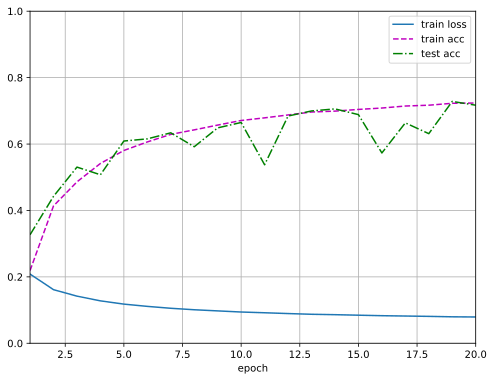

In [7]:
# 过拟合了

import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear
from d2l import torch as d2l
from IPython import display
from torch.nn import ReLU6


# 定义训练的设备，是用cpu进行训练测试还是gpu进行测试训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])


# 构建训练数据集dataset_train
dataset_train = torchvision.datasets.CIFAR10(root="./dataset", train=True, transform=transform_train, download=True)

# 构建测试数据集dataset_test
dataset_test = torchvision.datasets.CIFAR10(root="./dataset", train=False, transform=transform_test, download=True)

train_len = len(dataset_train)
test_len = len(dataset_test)
print(f"训练数据集的长度为:{train_len}")       # 输出训练集和测试集的长度
print(f"测试数据集的长度为:{test_len}")

# 加载训练集train_loader
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64, shuffle=True)

# 加载测试集test_loader
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64, shuffle=True)

batch_size = 64

# 将预测类别y_hat与真实y类别进行比较，计算预测正确的个数
def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis=1)     # 获得预测类别
    cmp = y_hat.type(y.dtype) == y   # 将预测类别和真实y类别进行比较
    return cmp.sum()

# 我们可以评估在任意模型net上的准确率
def evaluate_accuracy(net, data_iter):
    true_sum = 0                          # 在整个data_iter中预测正确的数量
    for data in data_iter:
        X, y = data                      # 获取输入特征X和真实预测y
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)                   # 输入特征X经过模型的计算，得到预测分类y_hat
        true_sum += accuracy(y_hat, y)   # 每次累加在当前batch中预测正确的数量
    return true_sum / (len(data_iter) * batch_size)


# 训练模型一个迭代周期
def train_epoch(net, train_iter, loss, updater):
    # 最终返回训练损失和训练准确率
    train_loss = 0
    train_acc = 0
    for data in train_iter:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)          # 向前传播，通过网络模型计算预测值y_hat
        l = loss(y_hat, y)      # 计算损失
        if isinstance(updater, torch.optim.Optimizer):    # 如果不是我们自己实现的，是调用的优化器就走这里
            train_loss += l * batch_size   # 累加总损失
            updater.zero_grad()
            l.backward()
            updater.step()
        else:
            train_loss += l.sum()
            l.sum().backward()      # 反向传播，计算梯度
            updater(batch_size)     # 利用梯度，更新模型参数

        train_acc += accuracy(y_hat, y)   # 累加正确预测数
    # 返回平均损失和平均准确率
    print(train_loss / (len(train_iter) * batch_size))
    return train_loss / (len(train_iter) * batch_size * 10), train_acc / (len(train_iter) * batch_size)


class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(8, 6)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                b = b.detach().cpu().numpy() if isinstance(b, torch.Tensor) else b
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 训练函数
def train(net, train_iter, test_iter, loss, epochs, updater):
    # 实例化绘图类
    animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(epochs):      # 训练epochs轮
        train_metrics = train_epoch(net, train_iter, loss, updater)   # 训练一个epoch
        test_acc = evaluate_accuracy(net, test_iter)                   # 测试一个epoch
        animator.add(epoch + 1, train_metrics + (test_acc,))           # 绘图




# 定义一个简单的神经网络模型
# 该模型包含一个展平层和一个全连接层
net = nn.Sequential(

    # 卷积层，参数：输入3通道，输出32通道，卷积核5，填充2       输入32通道的tensor(3, 32, 32)，输出32通道的tensor(32, 32, 32)
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 32, 32)，输出32通道的tensor(32, 16, 16)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出32通道，卷积核5，填充2      输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 16, 16)
            Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入32通道的tensor(32, 16, 16)，输出32通道的tensor(32, 8, 8)
            MaxPool2d(kernel_size=2),

            # 卷积层，参数：输入32通道，输出64通道，卷积核5，填充2      输入32通道的tensor(32, 8, 8)，输出64通道的tensor(64, 8, 8)
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),

            # 最大池化，参数：池化核2                                 输入64通道的tensor(64, 8,8)，输出64通道的tensor(64, 4, 4)
            MaxPool2d(kernel_size=2),

            # 展平                                                  输入64通道的tensor(64, 4, 4)，输出tensor 64 * 4 * 4
            Flatten(),

            # 线性层（全连接层），in_features:表示输入到该层的特征数量，out_features:表示输出张量输出特征数量    输入64 * 4 * 4，输出10
            Linear(in_features=64*4*4, out_features=64),
            ReLU6(),
            # 线性层（全连接层），参数：输入64，输出10                 输入64，输出10
            Linear(in_features=64, out_features=10)
)

# 定义权重初始化函数
def init_weights(m):
    if type(m) == nn.Linear:                 # 只对全连接层进行初始化
        nn.init.normal_(m.weight, std=0.01)  # 使用正态分布初始化权重，标准差为0.01

net.apply(init_weights)        # 应用权重初始化函数到模型的所有层

net = net.to(device)

loss = nn.CrossEntropyLoss()   # 定义损失函数，使用交叉熵损失函数，适用于多分类问题

weight_decay = 0.001     # 权重衰减，加入正则化
trainer = torch.optim.SGD(net.parameters(), lr=0.05, weight_decay = weight_decay)

num_epochs = 20
train(net, train_loader, test_loader, loss, num_epochs, trainer)
